In [1197]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

from pandas import datetime
import math, time
import itertools
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import optuna
import torch.utils.data as utils

# for LSTM reproducibility
%env CUBLAS_WORKSPACE_CONFIG=:4096:2
%env CUDA_LAUNCH_BLOCKING=1
        
seed = 211
np.random.seed(seed)
torch.manual_seed(seed)

env: CUBLAS_WORKSPACE_CONFIG=:4096:2
env: CUDA_LAUNCH_BLOCKING=1


<ipython-input-1197-c3b0ea2d3d79>:9: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [1198]:
def load_nasdaq(use_fed_data = True):
    filepath = 'input/NASDAQ_DAYLY.csv'
    nasdaq = pd.read_csv(filepath)
    nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format = '%Y-%m-%d')
    #nasdaq = nasdaq[nasdaq['Date'] > datetime.datetime(2018, 1, 1)]
    nasdaq = nasdaq.set_index('Date')
    nasdaq = nasdaq[['Close']]
    filepath = 'input/WALCL.csv'
    assets = pd.read_csv(filepath)
    assets['DATE'] = pd.to_datetime(assets['DATE'], format = '%Y-%m-%d')
    assets = assets.rename(columns={'DATE':'Date',"WALCL":'Millions_of_Dollars'})
    assets.set_index('Date',inplace=True)
    nasdaq['Assets'] = assets['Millions_of_Dollars']
    nasdaq = nasdaq.dropna()
    scaled = nasdaq.copy()
    scaler1 = MinMaxScaler(feature_range=(min(nasdaq['Close'])/max(nasdaq['Close']), 1))
    #scaler1 = MinMaxScaler(feature_range=(0.1, 1))
    scaler2 = MinMaxScaler(feature_range=(min(nasdaq['Assets'])/max(nasdaq['Assets']), 1))
    #scaler2 = MinMaxScaler(feature_range=(0.1, 1))
    scaled ['Close'] = scaler1.fit_transform(scaled['Close'].values.reshape(-1,1))
    scaled ['Assets'] = scaler2.fit_transform(scaled['Assets'].values.reshape(-1,1))
    if not use_fed_data:
        del nasdaq['Assets']
        del scaled['Assets']
    return nasdaq, scaled, scaler1, scaler2    
        
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  

In [1199]:
nasdaq

,Close,Assets
Date,,
2002-12-18,1013.669983,719542.0
2003-01-08,1042.520020,723762.0
2003-01-15,1073.599976,720074.0
2003-01-22,1006.510010,735953.0
2003-01-29,1016.559998,712809.0
...,...,...
2021-05-26,13702.740234,7903541.0
2021-06-02,13675.790039,7935703.0
2021-06-09,13814.940430,7952327.0


In [1200]:
scaled

,Close,Assets
Date,,
2002-12-18,0.071014,0.088811
2003-01-08,0.073035,0.089332
2003-01-15,0.075212,0.088877
2003-01-22,0.070512,0.090837
2003-01-29,0.071216,0.087980
...,...,...
2021-05-26,0.959963,0.975512
2021-06-02,0.958075,0.979481
2021-06-09,0.967823,0.981533


In [1201]:
# function to create train, test data given stock data and sequence lengt
def load_data(stock, look_back, batch_size = 1, prev_perm = None ,use_perm = True):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - 2*(test_set_size)
    np.random.seed(seed)
    if prev_perm is not None:
        rand_perm = prev_perm
    else:
        rand_perm = np.random.permutation(data.shape[0])
    if use_perm: 
        data = data[rand_perm,:,:]
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,0].reshape(-1,1)
    x_val = data[train_set_size:train_set_size+test_set_size,:-1,:]
    y_val = data[train_set_size:train_set_size+test_set_size,-1,0].reshape(-1,1) 
    x_test = data[train_set_size+test_set_size:,:-1]
    y_test = data[train_set_size+test_set_size:,-1,0].reshape(-1,1)

    
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)
    x_val = torch.from_numpy(x_val).type(torch.Tensor).to(device)
    y_val = torch.from_numpy(y_val).type(torch.Tensor).to(device)
    
    train_loader = utils.DataLoader(utils.TensorDataset(x_train,y_train),batch_size=batch_size)
    
      
    
    return x_test, y_test, x_train, y_train, x_val, y_val, train_loader

x_test, y_test, x_train, y_train, x_val, y_val, train_loader = load_data(nasdaq, 10, 8)
print(len(train_loader))
print(x_test.shape)
print(x_val.shape)
print(x_train.shape)
print(y_test.shape)
print(y_train.shape)

72
torch.Size([189, 10, 2])
torch.Size([189, 10, 2])
torch.Size([569, 10, 2])
torch.Size([189, 1])
torch.Size([569, 1])


In [1202]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        torch.manual_seed(seed)
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        torch.manual_seed(seed)
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [1203]:
def objective(trial):
    look_back = trial.suggest_int("Look Back",10,50,step=5)
    batch_size = trial.suggest_categorical('Batch Size', [4,8,16,32,64])
    hidden_dim = trial.suggest_categorical('Hidden Dim', [16,32,64,128,256])
    num_layers = trial.suggest_int("N layers",1,3)
    lr = trial.suggest_float("Learning Rate",1e-4,0.1,log=True)
    num_iters = 3000 #trial.suggest_int("Num Iters",2000,2000,step=500)
    factor = trial.suggest_float('Factor',0.55,0.95,step=0.1)
    #patience = trial.suggest_int("Patience",5,5)
    
    x_test, y_test, x_train, y_train, x_val, y_val, train_loader= load_data(scaled, look_back, batch_size, use_perm=True)
    output_dim = 1
    if model_name == "GRU":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    elif model_name == "LSTM":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
        
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = min(num_iters//len(train_loader),100)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data,target) in enumerate(train_loader):

            # Forward pass
            y_train_pred = model(data)
            MSE_loss = loss_fn(y_train_pred, target)
            loss = torch.sqrt(MSE_loss)
            train_loss += MSE_loss.item()
            # Zero out gradient, else they will accumulate between epochs
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
            
        train_loss = math.sqrt(train_loss/len(train_loader))
        y_val_pred = model(x_val)
        val_loss = torch.sqrt(loss_fn(y_val_pred, y_val)).item()
        scheduler.step(val_loss)
        trial.report(val_loss, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return val_loss

In [1204]:
# now we can run the experiment
def conduct_study (study_name, model_name, n_trials = 100, timeout=180*60):
    sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(study_name=study_name, direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials, timeout=timeout)

    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))
    return study

In [1205]:
def train(best_trial, model_name):
    look_back = best_trial.params['Look Back']
    batch_size = best_trial.params['Batch Size']
    hidden_dim = best_trial.params['Hidden Dim']
    num_layers = best_trial.params['N layers']
    lr = best_trial.params['Learning Rate']
    num_iters = 3000 #best_trial.params["Num Iters"]
    factor = best_trial.params['Factor']
    #patience = best_trial.params['Patience']
    
    x_test, y_test, x_train, y_train, x_val, y_val, train_loader= load_data(scaled, look_back, batch_size, use_perm=True)
    output_dim = 1
    if model_name == "GRU":
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
    elif model_name == "LSTM":
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
        
    loss_fn = torch.nn.MSELoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    num_epochs = min(num_iters//len(train_loader),100)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=factor, patience=5)
    hist = np.zeros(num_epochs)
    print("\nTraining Loss:")
    for epoch in range(num_epochs):
        train_loss = 0
        for batch_idx, (data,target) in enumerate(train_loader):

            # Forward pass
            y_train_pred = model(data)
            MSE_loss = loss_fn(y_train_pred, target)
            loss = torch.sqrt(MSE_loss)
            train_loss += MSE_loss.item()
            # Zero out gradient, else they will accumulate between epochs
            optimizer.zero_grad()

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()
            
        train_loss = math.sqrt(train_loss/len(train_loader))
        y_val_pred = model(x_val)
        val_loss = torch.sqrt(loss_fn(y_val_pred, y_val)).item()
        scheduler.step(val_loss)
        
        hist[epoch] = val_loss
        if epoch == num_epochs-1:
            print("Last Epoch", epoch, "MSE: ", train_loss)
    
    # plot loss
    plt.plot(hist, label="Training loss")
    plt.legend()
    plt.show()
    
    # make predictions
    y_test_pred = model(x_test)
    y_train_pred = model(x_train)
    y_val_pred = model(x_val)
    # invert predictions

    y_train_pred = scaler1.inverse_transform(y_train_pred.cpu().detach().numpy())
    y_train = scaler1.inverse_transform(y_train.detach().cpu().numpy())
    y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
    y_test = scaler1.inverse_transform(y_test.cpu().detach().numpy())
    y_val_pred = scaler1.inverse_transform(y_val_pred.cpu().detach().numpy())
    y_val = scaler1.inverse_transform(y_val.cpu().detach().numpy())
    return y_train_pred, y_train, y_test_pred, y_test, y_val_pred, y_val, model

In [1206]:
def plot_results(model, last = 20):
    x_test, y_test, x_train, y_train, x_val, y_val, train_loader= load_data(scaled, look_back, use_perm = False)
    x = torch.cat((x_train,x_val,x_test))
    y = torch.cat((y_train,y_val,y_test))
    y_pred = model(x)
    y_pred = scaler1.inverse_transform(y_pred.cpu().detach().numpy())
    y = scaler1.inverse_transform(y.cpu().detach().numpy())
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(nasdaq[-len(y):].index, y, color = 'red', label = 'Real NASDAQ Price')
    axes.plot(nasdaq[-len(y):].index, y_pred, color = 'blue', label = 'Predicted NASDAQ Price')
    #axes.xticks(np.arange(0,394,50))
    plt.title('NASDAQ-100 Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('NASDAQ-100 Stock Price')
    plt.legend()
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.xaxis_date()
    axes.plot(nasdaq[-last:].index, y[-last:], '.', color = 'red', label = 'Real NASDAQ Price')
    axes.plot(nasdaq[-last:].index, y_pred[-last:], '.', color = 'blue', label = 'Predicted NASDAQ Price')
    plt.title('NASDAQ-100 Stock Price Prediction - Last Weeks')
    plt.xlabel('Time')
    plt.ylabel('NASDAQ-100 Stock Price')
    plt.legend()

In [1207]:
def predict_results(model, n=5):
    data_raw = scaled.values
    predictions = []
    data = np.array(data_raw[len(data_raw) - look_back:])
    x_test = data.reshape(1,data.shape[0],data.shape[1])
    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
    for _ in range(n):
        y_test_pred = model(x_test)
        if input_dim == 2:
            tmp = torch.tensor([[[y_test_pred[0,0].item(),2*x_test[0,-1,1].item()-x_test[0,-2,1].item()]]]).to(device)
        elif input_dim ==1: 
            tmp = torch.tensor([[[y_test_pred[0,0].item()]]]).to(device)
        x_test = torch.cat((x_test,tmp),1)[:,1:,:]
        y_test_pred = scaler1.inverse_transform(y_test_pred.cpu().detach().numpy())
        predictions.append(y_test_pred.item())
        
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.plot(range(1,n+1),predictions)
    plt.xticks(range(1,n+1))
    plt.title('NASDAQ-100 Stock Price Future Prediction - Last Weeks')
    plt.xlabel('Weeks Ahead')
    plt.ylabel('NASDAQ-100 Stock Price')
    plt.show()
    print(predictions)

In [1208]:
def study_results(study, model_name, n=5, last=20):
    print("Best trial:")
    best_trial = study.best_trial

    print("Validation Loss: ", best_trial.value)
    print(best_trial.params)
    #optuna.visualization.plot_param_importances(best_trial)
    y_train_pred, y_train, y_test_pred, y_test, y_val_pred, y_val, model = train(best_trial, model_name)
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
    print('\n\nModel Train Score: %.2f RMSE' % (trainScore))
    valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_pred[:,0]))
    print('Model Validation Score: %.2f RMSE' % (valScore))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
    print('Model Test Score: %.2f RMSE\n\n' % (testScore))
    y = np.concatenate((y_train,y_val,y_test))
    y_pred = np.concatenate((y_train_pred,y_val_pred,y_test_pred))
    totScore = math.sqrt(mean_squared_error(y[:,0], y_pred[:,0]))
    print('Aggregated Score: %.2f RMSE\n\n' % (totScore))
    plot_results(model)
    predict_results(model)

# Optuna Hyper Parameter Search

In [1209]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
n_trials = 500

In [1210]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  
input_dim = 2
study_gru = conduct_study('GRU', 'GRU', n_trials)

[I 2021-06-26 03:02:45,770] A new study created in memory with name: GRU
[I 2021-06-26 03:03:00,830] Trial 0 finished with value: 0.00843887496739626 and parameters: {'Look Back': 35, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 3, 'Learning Rate': 0.005717693567618212, 'Factor': 0.75}. Best is trial 0 with value: 0.00843887496739626.
[I 2021-06-26 03:03:10,076] Trial 1 finished with value: 0.012656274251639843 and parameters: {'Look Back': 10, 'Batch Size': 16, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.00011649975584070954, 'Factor': 0.55}. Best is trial 0 with value: 0.00843887496739626.
[I 2021-06-26 03:03:22,048] Trial 2 finished with value: 0.44890764355659485 and parameters: {'Look Back': 40, 'Batch Size': 4, 'Hidden Dim': 128, 'N layers': 2, 'Learning Rate': 0.05484019927036393, 'Factor': 0.75}. Best is trial 0 with value: 0.00843887496739626.
[I 2021-06-26 03:03:29,880] Trial 3 finished with value: 0.01044280081987381 and parameters: {'Look Back': 30, 'Batch Size':

[I 2021-06-26 03:07:28,628] Trial 73 pruned. 
[I 2021-06-26 03:07:29,149] Trial 74 pruned. 
[I 2021-06-26 03:07:29,251] Trial 75 pruned. 
[I 2021-06-26 03:07:29,430] Trial 76 pruned. 
[I 2021-06-26 03:07:29,934] Trial 77 pruned. 
[I 2021-06-26 03:07:30,275] Trial 78 pruned. 
[I 2021-06-26 03:07:30,500] Trial 79 pruned. 
[I 2021-06-26 03:07:30,559] Trial 80 pruned. 
[I 2021-06-26 03:07:31,027] Trial 81 pruned. 
[I 2021-06-26 03:07:41,296] Trial 82 finished with value: 0.010142172686755657 and parameters: {'Look Back': 15, 'Batch Size': 4, 'Hidden Dim': 256, 'N layers': 2, 'Learning Rate': 0.00023783990840421464, 'Factor': 0.65}. Best is trial 0 with value: 0.00843887496739626.
[I 2021-06-26 03:07:42,741] Trial 83 pruned. 
[I 2021-06-26 03:07:43,795] Trial 84 pruned. 
[I 2021-06-26 03:07:44,305] Trial 85 pruned. 
[I 2021-06-26 03:07:44,775] Trial 86 pruned. 
[I 2021-06-26 03:07:44,932] Trial 87 pruned. 
[I 2021-06-26 03:07:45,729] Trial 88 pruned. 
[I 2021-06-26 03:07:45,930] Trial 89 pr

[I 2021-06-26 03:09:44,211] Trial 188 pruned. 
[I 2021-06-26 03:09:44,475] Trial 189 pruned. 
[I 2021-06-26 03:09:45,063] Trial 190 pruned. 
[I 2021-06-26 03:09:45,543] Trial 191 pruned. 
[I 2021-06-26 03:09:46,020] Trial 192 pruned. 
[I 2021-06-26 03:09:46,466] Trial 193 pruned. 
[I 2021-06-26 03:09:46,911] Trial 194 pruned. 
[I 2021-06-26 03:09:47,646] Trial 195 pruned. 
[I 2021-06-26 03:09:48,156] Trial 196 pruned. 
[I 2021-06-26 03:09:48,370] Trial 197 pruned. 
[I 2021-06-26 03:09:48,851] Trial 198 pruned. 
[I 2021-06-26 03:09:49,172] Trial 199 pruned. 
[I 2021-06-26 03:09:49,678] Trial 200 pruned. 
[I 2021-06-26 03:09:50,149] Trial 201 pruned. 
[I 2021-06-26 03:09:50,623] Trial 202 pruned. 
[I 2021-06-26 03:09:51,076] Trial 203 pruned. 
[I 2021-06-26 03:09:51,556] Trial 204 pruned. 
[I 2021-06-26 03:09:51,996] Trial 205 pruned. 
[I 2021-06-26 03:09:52,144] Trial 206 pruned. 
[I 2021-06-26 03:09:52,277] Trial 207 pruned. 
[I 2021-06-26 03:09:52,379] Trial 208 pruned. 
[I 2021-06-26

[I 2021-06-26 03:12:22,060] Trial 289 pruned. 
[I 2021-06-26 03:12:22,695] Trial 290 pruned. 
[I 2021-06-26 03:12:22,798] Trial 291 pruned. 
[I 2021-06-26 03:12:22,909] Trial 292 pruned. 
[I 2021-06-26 03:12:23,646] Trial 293 pruned. 
[I 2021-06-26 03:12:24,163] Trial 294 pruned. 
[I 2021-06-26 03:12:24,349] Trial 295 pruned. 
[I 2021-06-26 03:12:24,745] Trial 296 pruned. 
[I 2021-06-26 03:12:25,301] Trial 297 pruned. 
[I 2021-06-26 03:12:25,785] Trial 298 pruned. 
[I 2021-06-26 03:12:26,259] Trial 299 pruned. 
[I 2021-06-26 03:12:26,454] Trial 300 pruned. 
[I 2021-06-26 03:12:26,964] Trial 301 pruned. 
[I 2021-06-26 03:12:35,915] Trial 302 finished with value: 0.01380264200270176 and parameters: {'Look Back': 10, 'Batch Size': 8, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.0024869972947669182, 'Factor': 0.75}. Best is trial 0 with value: 0.00843887496739626.
[I 2021-06-26 03:12:36,560] Trial 303 pruned. 
[I 2021-06-26 03:12:38,521] Trial 304 pruned. 
[I 2021-06-26 03:12:39,817

[I 2021-06-26 03:14:18,124] Trial 408 pruned. 
[I 2021-06-26 03:14:19,759] Trial 409 pruned. 
[I 2021-06-26 03:14:23,327] Trial 410 pruned. 
[I 2021-06-26 03:14:23,989] Trial 411 pruned. 
[I 2021-06-26 03:14:24,520] Trial 412 pruned. 
[I 2021-06-26 03:14:25,046] Trial 413 pruned. 
[I 2021-06-26 03:14:25,576] Trial 414 pruned. 
[I 2021-06-26 03:14:36,270] Trial 415 finished with value: 0.013507502153515816 and parameters: {'Look Back': 25, 'Batch Size': 4, 'Hidden Dim': 128, 'N layers': 2, 'Learning Rate': 0.0009354854160806491, 'Factor': 0.75}. Best is trial 0 with value: 0.00843887496739626.
[I 2021-06-26 03:14:36,508] Trial 416 pruned. 
[I 2021-06-26 03:14:50,198] Trial 417 finished with value: 0.010536772198975086 and parameters: {'Look Back': 25, 'Batch Size': 4, 'Hidden Dim': 128, 'N layers': 3, 'Learning Rate': 0.0011337534738599666, 'Factor': 0.75}. Best is trial 0 with value: 0.00843887496739626.
[I 2021-06-26 03:14:50,738] Trial 418 pruned. 
[I 2021-06-26 03:14:51,271] Trial 4

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  454
  Number of complete trials:  46


In [1211]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  
input_dim = 2
study_lstm = conduct_study ('LSTM', 'LSTM', n_trials)

[I 2021-06-26 03:16:39,377] A new study created in memory with name: LSTM
[I 2021-06-26 03:16:44,410] Trial 0 finished with value: 0.011329416185617447 and parameters: {'Look Back': 30, 'Batch Size': 32, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.0007625142268132246, 'Factor': 0.95}. Best is trial 0 with value: 0.011329416185617447.
[I 2021-06-26 03:16:55,892] Trial 1 finished with value: 0.012901894748210907 and parameters: {'Look Back': 15, 'Batch Size': 4, 'Hidden Dim': 32, 'N layers': 3, 'Learning Rate': 0.0002433760192810435, 'Factor': 0.8500000000000001}. Best is trial 0 with value: 0.011329416185617447.
[I 2021-06-26 03:17:03,124] Trial 2 finished with value: 0.010299893096089363 and parameters: {'Look Back': 10, 'Batch Size': 32, 'Hidden Dim': 16, 'N layers': 3, 'Learning Rate': 0.05946577537923222, 'Factor': 0.8500000000000001}. Best is trial 2 with value: 0.010299893096089363.
[I 2021-06-26 03:17:10,568] Trial 3 finished with value: 0.009711342863738537 and parameter

[I 2021-06-26 03:20:11,727] Trial 91 pruned. 
[I 2021-06-26 03:20:13,924] Trial 92 pruned. 
[I 2021-06-26 03:20:29,117] Trial 93 finished with value: 0.008960503153502941 and parameters: {'Look Back': 50, 'Batch Size': 4, 'Hidden Dim': 16, 'N layers': 3, 'Learning Rate': 0.006173950609551168, 'Factor': 0.8500000000000001}. Best is trial 4 with value: 0.008704914711415768.
[I 2021-06-26 03:20:36,387] Trial 94 pruned. 
[I 2021-06-26 03:20:37,158] Trial 95 pruned. 
[I 2021-06-26 03:20:37,757] Trial 96 pruned. 
[I 2021-06-26 03:20:37,815] Trial 97 pruned. 
[I 2021-06-26 03:20:37,938] Trial 98 pruned. 
[I 2021-06-26 03:20:38,383] Trial 99 pruned. 
[I 2021-06-26 03:20:38,497] Trial 100 pruned. 
[I 2021-06-26 03:20:39,254] Trial 101 pruned. 
[I 2021-06-26 03:20:41,451] Trial 102 pruned. 
[I 2021-06-26 03:20:42,222] Trial 103 pruned. 
[I 2021-06-26 03:20:42,937] Trial 104 pruned. 
[I 2021-06-26 03:20:45,185] Trial 105 pruned. 
[I 2021-06-26 03:20:45,935] Trial 106 pruned. 
[I 2021-06-26 03:20:

[I 2021-06-26 03:23:43,447] Trial 186 pruned. 
[I 2021-06-26 03:23:43,592] Trial 187 pruned. 
[I 2021-06-26 03:23:45,082] Trial 188 pruned. 
[I 2021-06-26 03:23:48,672] Trial 189 pruned. 
[I 2021-06-26 03:23:48,910] Trial 190 pruned. 
[I 2021-06-26 03:23:49,722] Trial 191 pruned. 
[I 2021-06-26 03:23:51,251] Trial 192 pruned. 
[I 2021-06-26 03:23:52,791] Trial 193 pruned. 
[I 2021-06-26 03:24:08,577] Trial 194 finished with value: 0.011682364158332348 and parameters: {'Look Back': 50, 'Batch Size': 4, 'Hidden Dim': 16, 'N layers': 3, 'Learning Rate': 0.0074573601143211035, 'Factor': 0.8500000000000001}. Best is trial 4 with value: 0.008704914711415768.
[I 2021-06-26 03:24:10,862] Trial 195 pruned. 
[I 2021-06-26 03:24:11,644] Trial 196 pruned. 
[I 2021-06-26 03:24:11,799] Trial 197 pruned. 
[I 2021-06-26 03:24:12,714] Trial 198 pruned. 
[I 2021-06-26 03:24:13,308] Trial 199 pruned. 
[I 2021-06-26 03:24:14,628] Trial 200 pruned. 
[I 2021-06-26 03:24:15,383] Trial 201 pruned. 
[I 2021-06

[I 2021-06-26 03:26:37,577] Trial 296 pruned. 
[I 2021-06-26 03:26:37,645] Trial 297 pruned. 
[I 2021-06-26 03:26:38,118] Trial 298 pruned. 
[I 2021-06-26 03:26:38,548] Trial 299 pruned. 
[I 2021-06-26 03:26:39,402] Trial 300 pruned. 
[I 2021-06-26 03:26:39,641] Trial 301 pruned. 
[I 2021-06-26 03:26:39,781] Trial 302 pruned. 
[I 2021-06-26 03:26:40,962] Trial 303 pruned. 
[I 2021-06-26 03:26:41,283] Trial 304 pruned. 
[I 2021-06-26 03:26:41,878] Trial 305 pruned. 
[I 2021-06-26 03:26:42,855] Trial 306 pruned. 
[I 2021-06-26 03:26:43,347] Trial 307 pruned. 
[I 2021-06-26 03:26:43,488] Trial 308 pruned. 
[I 2021-06-26 03:26:44,124] Trial 309 pruned. 
[I 2021-06-26 03:26:44,514] Trial 310 pruned. 
[I 2021-06-26 03:26:45,141] Trial 311 pruned. 
[I 2021-06-26 03:26:45,697] Trial 312 pruned. 
[I 2021-06-26 03:26:45,818] Trial 313 pruned. 
[I 2021-06-26 03:26:46,587] Trial 314 pruned. 
[I 2021-06-26 03:26:47,000] Trial 315 pruned. 
[I 2021-06-26 03:26:47,620] Trial 316 pruned. 
[I 2021-06-26

[I 2021-06-26 03:28:25,203] Trial 421 finished with value: 0.011334573850035667 and parameters: {'Look Back': 50, 'Batch Size': 4, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.00127385338441132, 'Factor': 0.8500000000000001}. Best is trial 4 with value: 0.008704914711415768.
[I 2021-06-26 03:28:26,409] Trial 422 pruned. 
[I 2021-06-26 03:28:26,756] Trial 423 pruned. 
[I 2021-06-26 03:28:39,023] Trial 424 finished with value: 0.011639419011771679 and parameters: {'Look Back': 50, 'Batch Size': 4, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.0015141867396273893, 'Factor': 0.8500000000000001}. Best is trial 4 with value: 0.008704914711415768.
[I 2021-06-26 03:28:39,146] Trial 425 pruned. 
[I 2021-06-26 03:28:39,485] Trial 426 pruned. 
[I 2021-06-26 03:28:40,099] Trial 427 pruned. 
[I 2021-06-26 03:28:40,182] Trial 428 pruned. 
[I 2021-06-26 03:28:40,517] Trial 429 pruned. 
[I 2021-06-26 03:28:41,704] Trial 430 pruned. 
[I 2021-06-26 03:28:53,431] Trial 431 finished with valu

[I 2021-06-26 03:32:35,322] Trial 488 finished with value: 0.00876096822321415 and parameters: {'Look Back': 40, 'Batch Size': 8, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.0028373020867893564, 'Factor': 0.55}. Best is trial 480 with value: 0.00860828347504139.
[I 2021-06-26 03:32:47,090] Trial 489 pruned. 
[I 2021-06-26 03:32:47,418] Trial 490 pruned. 
[I 2021-06-26 03:32:59,428] Trial 491 finished with value: 0.00876835361123085 and parameters: {'Look Back': 40, 'Batch Size': 8, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.0031018873123577905, 'Factor': 0.55}. Best is trial 480 with value: 0.00860828347504139.
[I 2021-06-26 03:33:12,240] Trial 492 pruned. 
[I 2021-06-26 03:33:25,549] Trial 493 finished with value: 0.008708239533007145 and parameters: {'Look Back': 40, 'Batch Size': 8, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.003322988139972545, 'Factor': 0.55}. Best is trial 480 with value: 0.00860828347504139.
[I 2021-06-26 03:33:40,822] Trial 494 finished

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  444
  Number of complete trials:  56


In [1212]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq(use_fed_data = False)
input_dim = 1
study_gru_no_fed = conduct_study ('GRU NO FED', 'GRU', n_trials)

[I 2021-06-26 03:34:01,762] A new study created in memory with name: GRU NO FED
[I 2021-06-26 03:34:10,729] Trial 0 finished with value: 0.035666294395923615 and parameters: {'Look Back': 15, 'Batch Size': 4, 'Hidden Dim': 16, 'N layers': 2, 'Learning Rate': 0.029667251951985624, 'Factor': 0.55}. Best is trial 0 with value: 0.035666294395923615.
[I 2021-06-26 03:34:18,637] Trial 1 finished with value: 0.013219897635281086 and parameters: {'Look Back': 30, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.0001539890376268593, 'Factor': 0.65}. Best is trial 1 with value: 0.013219897635281086.
[I 2021-06-26 03:34:26,099] Trial 2 finished with value: 0.00965938065201044 and parameters: {'Look Back': 30, 'Batch Size': 32, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.012595049817764848, 'Factor': 0.75}. Best is trial 2 with value: 0.00965938065201044.
[I 2021-06-26 03:34:35,033] Trial 3 finished with value: 0.011561368592083454 and parameters: {'Look Back': 25, 'Ba

[I 2021-06-26 03:37:04,832] Trial 88 pruned. 
[I 2021-06-26 03:37:05,103] Trial 89 pruned. 
[I 2021-06-26 03:37:05,629] Trial 90 pruned. 
[I 2021-06-26 03:37:05,812] Trial 91 pruned. 
[I 2021-06-26 03:37:05,966] Trial 92 pruned. 
[I 2021-06-26 03:37:06,118] Trial 93 pruned. 
[I 2021-06-26 03:37:06,308] Trial 94 pruned. 
[I 2021-06-26 03:37:06,417] Trial 95 pruned. 
[I 2021-06-26 03:37:10,737] Trial 96 pruned. 
[I 2021-06-26 03:37:10,818] Trial 97 pruned. 
[I 2021-06-26 03:37:11,189] Trial 98 pruned. 
[I 2021-06-26 03:37:11,457] Trial 99 pruned. 
[I 2021-06-26 03:37:11,678] Trial 100 pruned. 
[I 2021-06-26 03:37:11,791] Trial 101 pruned. 
[I 2021-06-26 03:37:11,897] Trial 102 pruned. 
[I 2021-06-26 03:37:12,027] Trial 103 pruned. 
[I 2021-06-26 03:37:12,211] Trial 104 pruned. 
[I 2021-06-26 03:37:12,313] Trial 105 pruned. 
[I 2021-06-26 03:37:12,878] Trial 106 pruned. 
[I 2021-06-26 03:37:13,154] Trial 107 pruned. 
[I 2021-06-26 03:37:13,249] Trial 108 pruned. 
[I 2021-06-26 03:37:13,54

[I 2021-06-26 03:38:47,091] Trial 195 pruned. 
[I 2021-06-26 03:38:55,266] Trial 196 finished with value: 0.009066667407751083 and parameters: {'Look Back': 30, 'Batch Size': 8, 'Hidden Dim': 256, 'N layers': 1, 'Learning Rate': 0.00822069889525257, 'Factor': 0.55}. Best is trial 116 with value: 0.008528511971235275.
[I 2021-06-26 03:39:03,352] Trial 197 finished with value: 0.008765200152993202 and parameters: {'Look Back': 30, 'Batch Size': 8, 'Hidden Dim': 256, 'N layers': 1, 'Learning Rate': 0.00896256645603077, 'Factor': 0.55}. Best is trial 116 with value: 0.008528511971235275.
[I 2021-06-26 03:39:03,693] Trial 198 pruned. 
[I 2021-06-26 03:39:03,907] Trial 199 pruned. 
[I 2021-06-26 03:39:04,125] Trial 200 pruned. 
[I 2021-06-26 03:39:04,344] Trial 201 pruned. 
[I 2021-06-26 03:39:04,552] Trial 202 pruned. 
[I 2021-06-26 03:39:04,788] Trial 203 pruned. 
[I 2021-06-26 03:39:04,992] Trial 204 pruned. 
[I 2021-06-26 03:39:05,365] Trial 205 pruned. 
[I 2021-06-26 03:39:05,595] Trial

[I 2021-06-26 03:40:13,882] Trial 317 pruned. 
[I 2021-06-26 03:40:13,984] Trial 318 pruned. 
[I 2021-06-26 03:40:21,288] Trial 319 finished with value: 0.008720563724637032 and parameters: {'Look Back': 35, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.01223788252356964, 'Factor': 0.55}. Best is trial 116 with value: 0.008528511971235275.
[I 2021-06-26 03:40:21,404] Trial 320 pruned. 
[I 2021-06-26 03:40:21,521] Trial 321 pruned. 
[I 2021-06-26 03:40:21,639] Trial 322 pruned. 
[I 2021-06-26 03:40:21,753] Trial 323 pruned. 
[I 2021-06-26 03:40:21,862] Trial 324 pruned. 
[I 2021-06-26 03:40:21,969] Trial 325 pruned. 
[I 2021-06-26 03:40:22,198] Trial 326 pruned. 
[I 2021-06-26 03:40:22,325] Trial 327 pruned. 
[I 2021-06-26 03:40:22,532] Trial 328 pruned. 
[I 2021-06-26 03:40:22,653] Trial 329 pruned. 
[I 2021-06-26 03:40:22,872] Trial 330 pruned. 
[I 2021-06-26 03:40:22,942] Trial 331 pruned. 
[I 2021-06-26 03:40:23,172] Trial 332 pruned. 
[I 2021-06-26 03:40:23,

[I 2021-06-26 03:41:26,968] Trial 435 pruned. 
[I 2021-06-26 03:41:27,332] Trial 436 pruned. 
[I 2021-06-26 03:41:27,699] Trial 437 pruned. 
[I 2021-06-26 03:41:34,360] Trial 438 finished with value: 0.02451862394809723 and parameters: {'Look Back': 30, 'Batch Size': 4, 'Hidden Dim': 64, 'N layers': 1, 'Learning Rate': 0.014767509276640355, 'Factor': 0.75}. Best is trial 116 with value: 0.008528511971235275.
[I 2021-06-26 03:41:34,706] Trial 439 pruned. 
[I 2021-06-26 03:41:35,069] Trial 440 pruned. 
[I 2021-06-26 03:41:35,428] Trial 441 pruned. 
[I 2021-06-26 03:41:35,814] Trial 442 pruned. 
[I 2021-06-26 03:41:36,199] Trial 443 pruned. 
[I 2021-06-26 03:41:36,277] Trial 444 pruned. 
[I 2021-06-26 03:41:36,640] Trial 445 pruned. 
[I 2021-06-26 03:41:36,992] Trial 446 pruned. 
[I 2021-06-26 03:41:37,370] Trial 447 pruned. 
[I 2021-06-26 03:41:37,750] Trial 448 pruned. 
[I 2021-06-26 03:41:38,094] Trial 449 pruned. 
[I 2021-06-26 03:41:44,724] Trial 450 pruned. 
[I 2021-06-26 03:41:45,1

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  464
  Number of complete trials:  36


In [1213]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq(use_fed_data = False)
input_dim = 1
study_lstm_no_fed = conduct_study('LSTM NO FED', 'LSTM', n_trials)

[I 2021-06-26 03:42:36,887] A new study created in memory with name: LSTM NO FED
[I 2021-06-26 03:42:57,730] Trial 0 finished with value: 0.01285311859101057 and parameters: {'Look Back': 50, 'Batch Size': 16, 'Hidden Dim': 256, 'N layers': 2, 'Learning Rate': 0.002424187616150743, 'Factor': 0.8500000000000001}. Best is trial 0 with value: 0.01285311859101057.
[I 2021-06-26 03:43:08,991] Trial 1 finished with value: 0.016184812411665916 and parameters: {'Look Back': 20, 'Batch Size': 8, 'Hidden Dim': 16, 'N layers': 3, 'Learning Rate': 0.00014521043718193275, 'Factor': 0.8500000000000001}. Best is trial 0 with value: 0.01285311859101057.
[I 2021-06-26 03:43:14,455] Trial 2 finished with value: 0.009081525728106499 and parameters: {'Look Back': 45, 'Batch Size': 64, 'Hidden Dim': 256, 'N layers': 1, 'Learning Rate': 0.00322991137100462, 'Factor': 0.8500000000000001}. Best is trial 2 with value: 0.009081525728106499.
[I 2021-06-26 03:43:21,124] Trial 3 finished with value: 0.015676820650

[I 2021-06-26 03:46:43,376] Trial 72 pruned. 
[I 2021-06-26 03:46:43,501] Trial 73 pruned. 
[I 2021-06-26 03:46:43,649] Trial 74 pruned. 
[I 2021-06-26 03:46:44,272] Trial 75 pruned. 
[I 2021-06-26 03:46:44,389] Trial 76 pruned. 
[I 2021-06-26 03:46:44,770] Trial 77 pruned. 
[I 2021-06-26 03:46:44,836] Trial 78 pruned. 
[I 2021-06-26 03:46:45,590] Trial 79 pruned. 
[I 2021-06-26 03:46:45,814] Trial 80 pruned. 
[I 2021-06-26 03:46:46,753] Trial 81 pruned. 
[I 2021-06-26 03:46:47,079] Trial 82 pruned. 
[I 2021-06-26 03:46:47,415] Trial 83 pruned. 
[I 2021-06-26 03:46:48,118] Trial 84 pruned. 
[I 2021-06-26 03:46:48,546] Trial 85 pruned. 
[I 2021-06-26 03:46:48,600] Trial 86 pruned. 
[I 2021-06-26 03:46:48,796] Trial 87 pruned. 
[I 2021-06-26 03:46:49,064] Trial 88 pruned. 
[I 2021-06-26 03:46:50,290] Trial 89 pruned. 
[I 2021-06-26 03:46:56,861] Trial 90 finished with value: 0.009516425430774689 and parameters: {'Look Back': 10, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning

[I 2021-06-26 03:49:04,573] Trial 161 finished with value: 0.008998299017548561 and parameters: {'Look Back': 35, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.006588733693396447, 'Factor': 0.65}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:49:04,784] Trial 162 pruned. 
[I 2021-06-26 03:49:12,472] Trial 163 finished with value: 0.00894757267087698 and parameters: {'Look Back': 35, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.006387595503565011, 'Factor': 0.65}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:49:12,673] Trial 164 pruned. 
[I 2021-06-26 03:49:12,882] Trial 165 pruned. 
[I 2021-06-26 03:49:13,093] Trial 166 pruned. 
[I 2021-06-26 03:49:14,696] Trial 167 pruned. 
[I 2021-06-26 03:49:19,208] Trial 168 pruned. 
[I 2021-06-26 03:49:19,429] Trial 169 pruned. 
[I 2021-06-26 03:49:19,614] Trial 170 pruned. 
[I 2021-06-26 03:49:26,399] Trial 171 finished with value: 0.008924228139221668 a

[I 2021-06-26 03:51:54,903] Trial 219 pruned. 
[I 2021-06-26 03:51:55,287] Trial 220 pruned. 
[I 2021-06-26 03:51:55,681] Trial 221 pruned. 
[I 2021-06-26 03:51:56,106] Trial 222 pruned. 
[I 2021-06-26 03:52:03,947] Trial 223 finished with value: 0.009010927751660347 and parameters: {'Look Back': 35, 'Batch Size': 4, 'Hidden Dim': 16, 'N layers': 1, 'Learning Rate': 0.008426392001360332, 'Factor': 0.8500000000000001}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:52:04,336] Trial 224 pruned. 
[I 2021-06-26 03:52:04,711] Trial 225 pruned. 
[I 2021-06-26 03:52:05,084] Trial 226 pruned. 
[I 2021-06-26 03:52:05,462] Trial 227 pruned. 
[I 2021-06-26 03:52:13,008] Trial 228 finished with value: 0.009177617728710175 and parameters: {'Look Back': 35, 'Batch Size': 4, 'Hidden Dim': 16, 'N layers': 1, 'Learning Rate': 0.00655414202144711, 'Factor': 0.8500000000000001}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:52:13,384] Trial 229 pruned. 
[I 202

[I 2021-06-26 03:54:04,434] Trial 309 pruned. 
[I 2021-06-26 03:54:04,823] Trial 310 pruned. 
[I 2021-06-26 03:54:05,200] Trial 311 pruned. 
[I 2021-06-26 03:54:05,252] Trial 312 pruned. 
[I 2021-06-26 03:54:05,663] Trial 313 pruned. 
[I 2021-06-26 03:54:06,059] Trial 314 pruned. 
[I 2021-06-26 03:54:13,625] Trial 315 finished with value: 0.009125360287725925 and parameters: {'Look Back': 35, 'Batch Size': 4, 'Hidden Dim': 16, 'N layers': 1, 'Learning Rate': 0.0044189179167451334, 'Factor': 0.8500000000000001}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:54:21,215] Trial 316 finished with value: 0.008835169486701488 and parameters: {'Look Back': 35, 'Batch Size': 4, 'Hidden Dim': 16, 'N layers': 1, 'Learning Rate': 0.004726198669179427, 'Factor': 0.8500000000000001}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:54:21,601] Trial 317 pruned. 
[I 2021-06-26 03:54:29,199] Trial 318 finished with value: 0.009084359742701054 and parameters: {'

[I 2021-06-26 03:56:31,928] Trial 389 pruned. 
[I 2021-06-26 03:56:31,989] Trial 390 pruned. 
[I 2021-06-26 03:56:32,370] Trial 391 pruned. 
[I 2021-06-26 03:56:32,451] Trial 392 pruned. 
[I 2021-06-26 03:56:32,840] Trial 393 pruned. 
[I 2021-06-26 03:56:33,045] Trial 394 pruned. 
[I 2021-06-26 03:56:41,315] Trial 395 finished with value: 0.008895584382116795 and parameters: {'Look Back': 35, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.011078454143649101, 'Factor': 0.75}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:56:41,446] Trial 396 pruned. 
[I 2021-06-26 03:56:41,571] Trial 397 pruned. 
[I 2021-06-26 03:56:49,870] Trial 398 finished with value: 0.0087519446387887 and parameters: {'Look Back': 35, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.011633832498978387, 'Factor': 0.65}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:56:50,081] Trial 399 pruned. 
[I 2021-06-26 03:56:50,202] Trial

[I 2021-06-26 03:59:13,668] Trial 477 finished with value: 0.008740381337702274 and parameters: {'Look Back': 35, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.011810114741763326, 'Factor': 0.65}. Best is trial 160 with value: 0.008591758087277412.
[I 2021-06-26 03:59:13,801] Trial 478 pruned. 
[I 2021-06-26 03:59:14,804] Trial 479 pruned. 
[I 2021-06-26 03:59:14,929] Trial 480 pruned. 
[I 2021-06-26 03:59:15,054] Trial 481 pruned. 
[I 2021-06-26 03:59:15,179] Trial 482 pruned. 
[I 2021-06-26 03:59:15,306] Trial 483 pruned. 
[I 2021-06-26 03:59:15,427] Trial 484 pruned. 
[I 2021-06-26 03:59:22,669] Trial 485 pruned. 
[I 2021-06-26 03:59:22,807] Trial 486 pruned. 
[I 2021-06-26 03:59:22,934] Trial 487 pruned. 
[I 2021-06-26 03:59:23,054] Trial 488 pruned. 
[I 2021-06-26 03:59:28,621] Trial 489 pruned. 
[I 2021-06-26 03:59:28,757] Trial 490 pruned. 
[I 2021-06-26 03:59:28,884] Trial 491 pruned. 
[I 2021-06-26 03:59:29,012] Trial 492 pruned. 
[I 2021-06-26 03:59:29

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  409
  Number of complete trials:  91


# Prediction with GRU

In [1214]:
optuna.visualization.plot_param_importances(study_gru)

Best trial:
Validation Loss:  0.00843887496739626
{'Look Back': 35, 'Batch Size': 16, 'Hidden Dim': 32, 'N layers': 3, 'Learning Rate': 0.005717693567618212, 'Factor': 0.75}

Training Loss:
Last Epoch 84 MSE:  0.008820995306773726


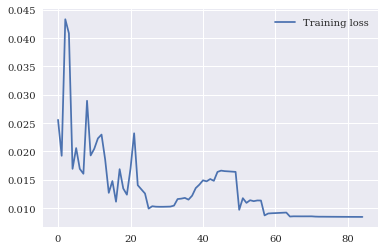



Model Train Score: 120.79 RMSE
Model Validation Score: 120.46 RMSE
Model Test Score: 169.43 RMSE


Aggregated Score: 131.88 RMSE




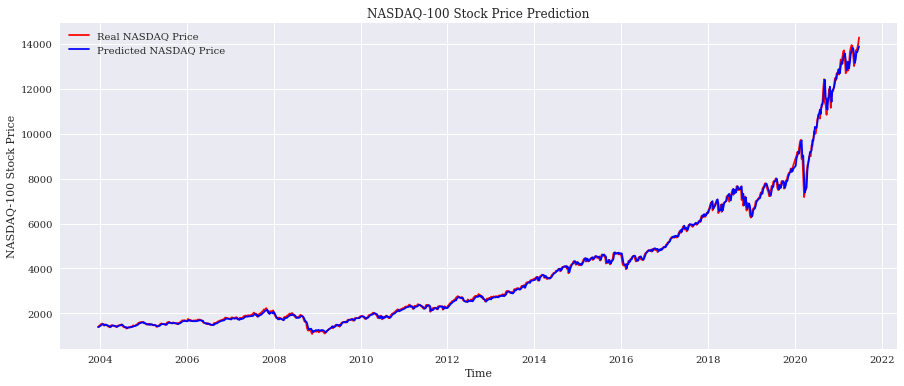

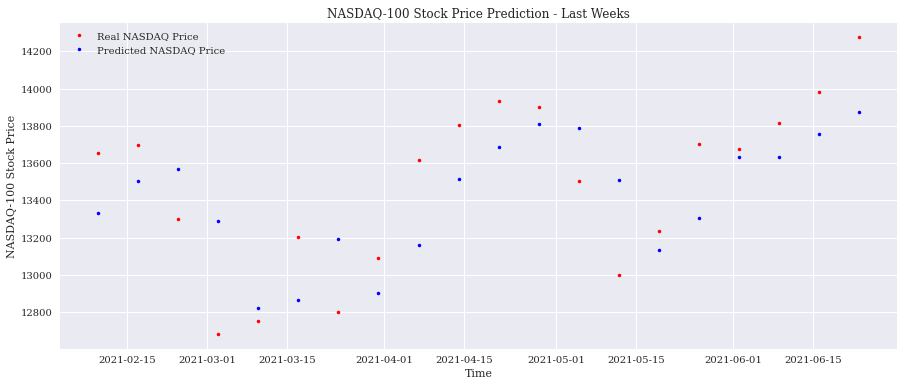

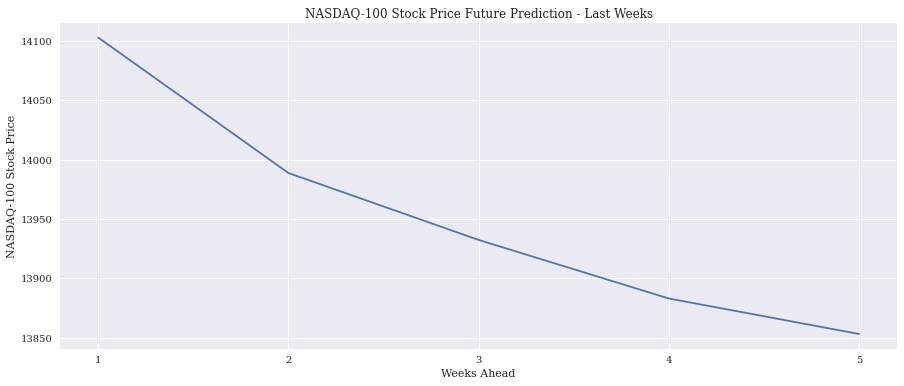

[14102.8251953125, 13988.7470703125, 13932.3984375, 13883.07421875, 13853.205078125]


In [1215]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  
input_dim = 2
study_results(study_gru,'GRU')

# Prediction with LSTM

In [1216]:
optuna.visualization.plot_param_importances(study_lstm)

Best trial:
Validation Loss:  0.00860828347504139
{'Look Back': 40, 'Batch Size': 8, 'Hidden Dim': 64, 'N layers': 2, 'Learning Rate': 0.0031859923602114257, 'Factor': 0.55}

Training Loss:
Last Epoch 42 MSE:  0.009897887951881642


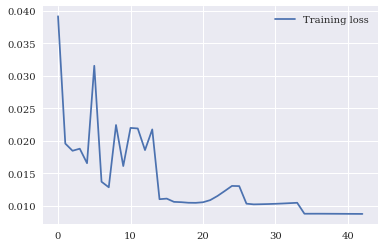



Model Train Score: 126.58 RMSE
Model Validation Score: 124.63 RMSE
Model Test Score: 150.54 RMSE


Aggregated Score: 131.33 RMSE




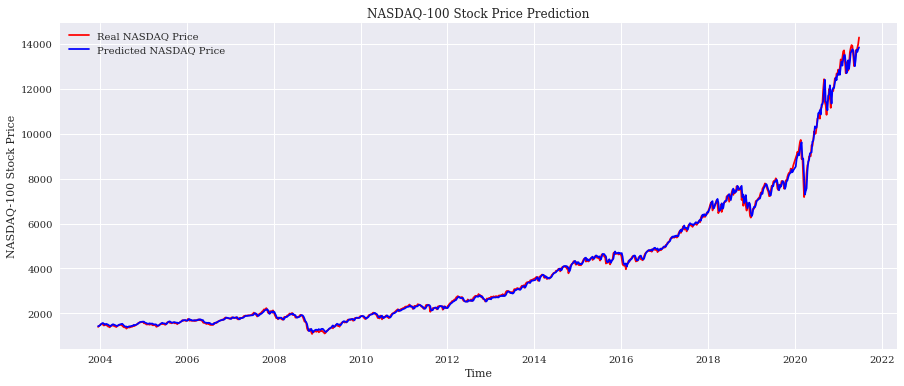

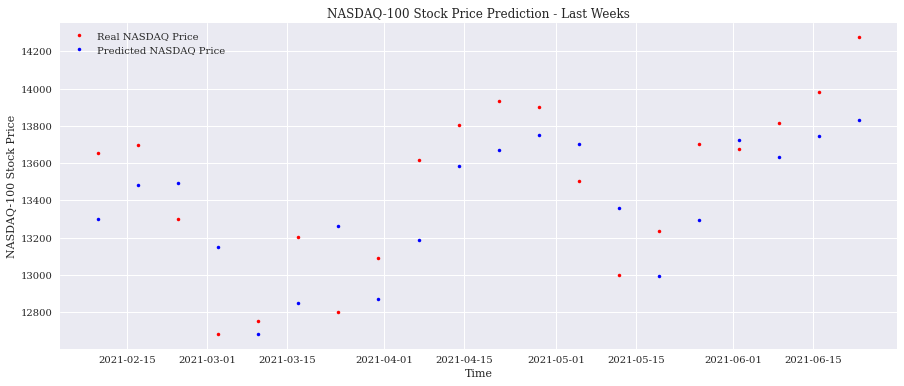

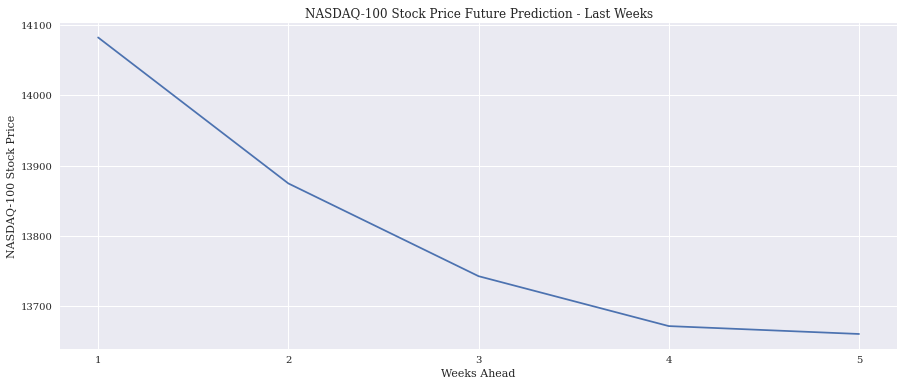

[14082.365234375, 13874.50390625, 13742.419921875, 13671.357421875, 13660.126953125]


In [1217]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq()  
input_dim = 2
study_results(study_lstm,'LSTM')

# Prediction with GRU without Fed Data

In [1218]:
optuna.visualization.plot_param_importances(study_gru_no_fed)

Best trial:
Validation Loss:  0.008528511971235275
{'Look Back': 35, 'Batch Size': 8, 'Hidden Dim': 256, 'N layers': 1, 'Learning Rate': 0.009169062994878229, 'Factor': 0.55}

Training Loss:
Last Epoch 41 MSE:  0.008922838843808178


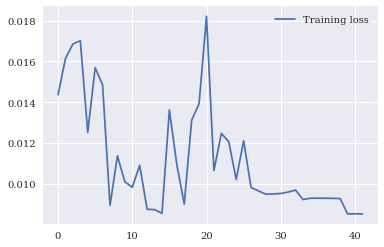



Model Train Score: 121.63 RMSE
Model Validation Score: 121.74 RMSE
Model Test Score: 172.82 RMSE


Aggregated Score: 133.44 RMSE




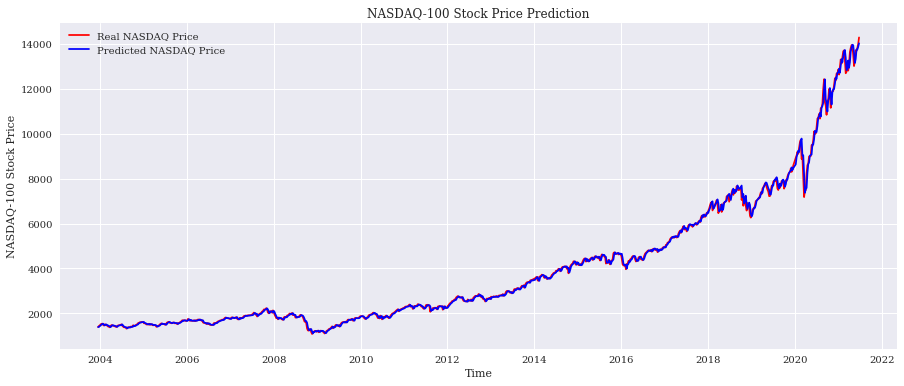

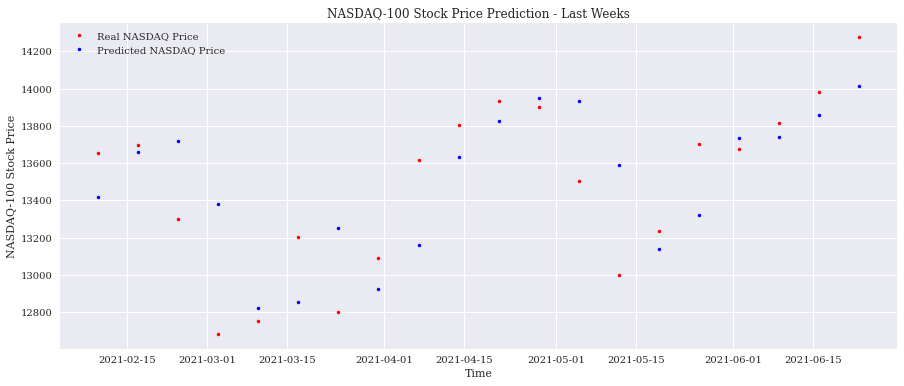

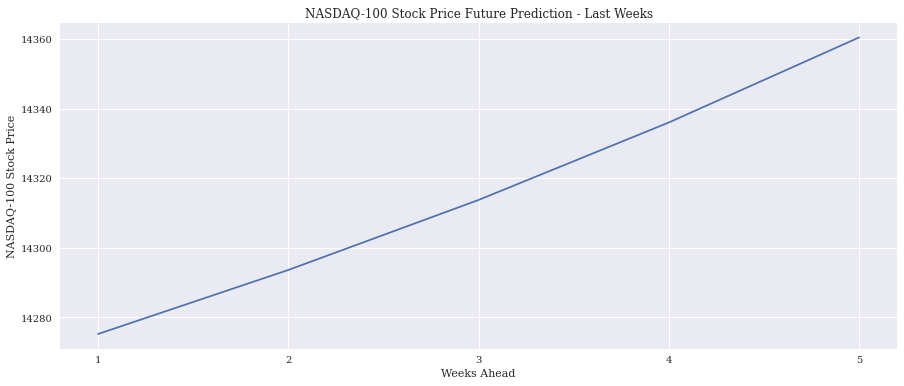

[14275.2490234375, 14293.6474609375, 14313.763671875, 14336.02734375, 14360.4609375]


In [1219]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq(use_fed_data = False)
input_dim = 1
study_results(study_gru_no_fed,'GRU')

# Prediction with LSTM without Fed Data

In [1220]:
optuna.visualization.plot_param_importances(study_lstm_no_fed)

Best trial:
Validation Loss:  0.008591758087277412
{'Look Back': 35, 'Batch Size': 8, 'Hidden Dim': 32, 'N layers': 1, 'Learning Rate': 0.007669153465919796, 'Factor': 0.65}

Training Loss:
Last Epoch 41 MSE:  0.008909080700350538


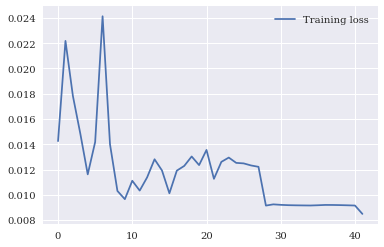



Model Train Score: 121.35 RMSE
Model Validation Score: 121.21 RMSE
Model Test Score: 174.95 RMSE


Aggregated Score: 133.75 RMSE




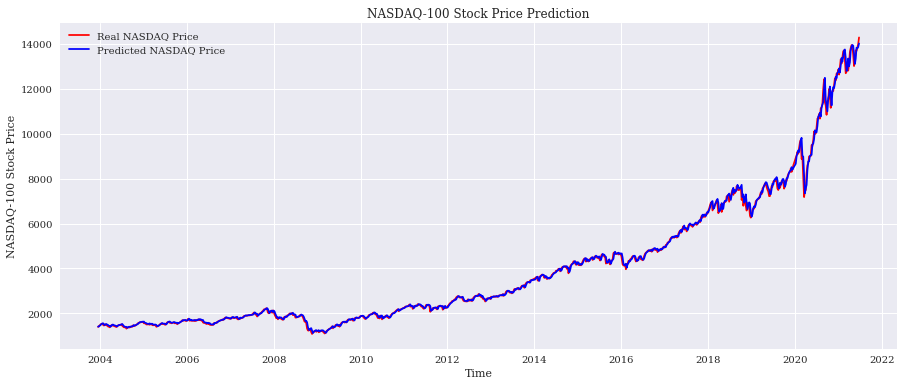

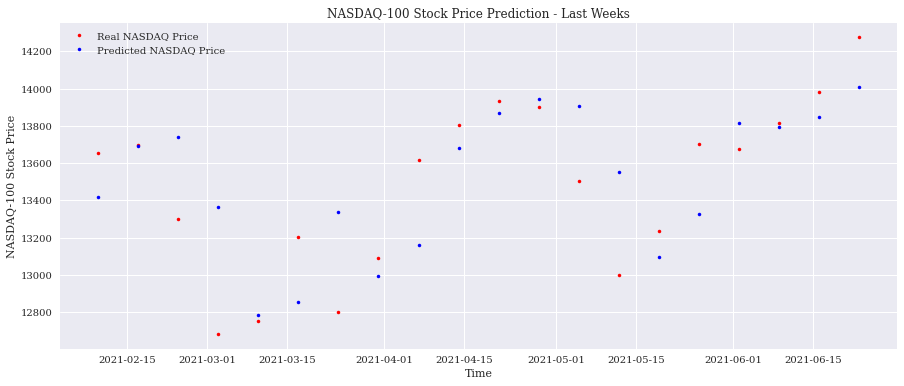

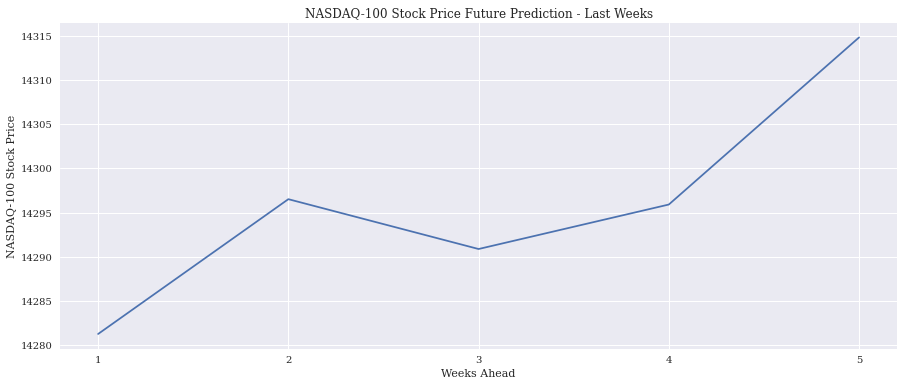

[14281.287109375, 14296.517578125, 14290.88671875, 14295.912109375, 14314.7880859375]


In [1221]:
nasdaq, scaled, scaler1, scaler2  = load_nasdaq(use_fed_data = False)
input_dim = 1
study_results(study_lstm_no_fed,'LSTM')

# Naive Predictor

In [1225]:
dt = nasdaq.index[-1]-nasdaq.index[0]
dt = int(dt.days/7)
avg_weekly_gain = (nasdaq.iloc[-1,0]/nasdaq.iloc[0,0])**(1/dt)
#avg_weekly_gain = 1
#dt = len(nasdaq)
print('Nasdaq avegage weekly gain: %.4f' % (avg_weekly_gain))
dates = nasdaq.index
d0 = dates[0]
#naive = nasdaq.iloc[0,0]*avg_weekly_gain**((dates-d0).days/7)
naive = nasdaq['Close']*avg_weekly_gain
naiveScore = math.sqrt(mean_squared_error(naive[:-1], nasdaq['Close'][1:]))
print('Naive Predictor Score: %.2f RMSE' % (naiveScore))

Nasdaq avegage weekly gain: 1.0027
Naive Predictor Score: 131.68 RMSE


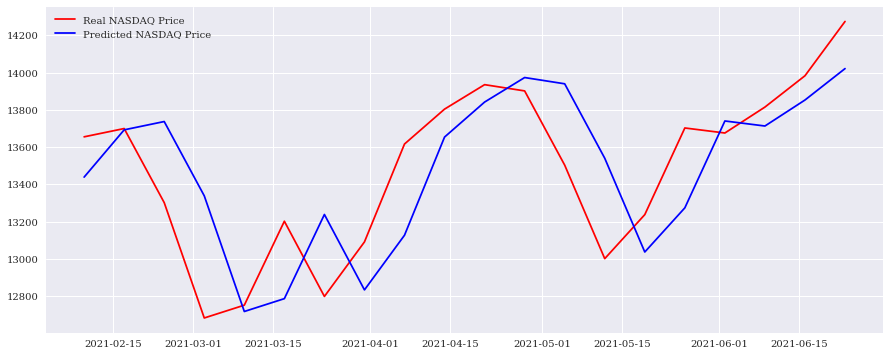

In [1223]:
figure, axes = plt.subplots(figsize=(15, 6))
last = 20
axes.xaxis_date()
axes.plot(nasdaq[-last:].index, nasdaq['Close'][-last:], color = 'red', label = 'Real NASDAQ Price')
axes.plot(nasdaq[-last:].index, naive[-last-1:-1], color = 'blue', label = 'Predicted NASDAQ Price')
plt.legend()